In [1]:
import argparse
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class LDAModel:
    def __init__(self, nComponents=2, regularization=0.01, solver="eigh"):
      self.nComponents = nComponents
      self.regularization = regularization
      self.solver = solver
      self.Eigens = None 
      self.classes_ = None
      self.classMeans = None
    def fit(self, X, y):
    
      # this will find all the unique classes in the dataset
      self.classes_ = np.unique(y)
      # this will get the number of features in the dataset
      n_features = X.shape[1]
      
      # this will  calculate the scatter and matrices
      WithinScatterMtrx, BetweenScatterMtrx = self.calculate_scatter_matrices(X, y)
      WithinScatterMtrx +=self.regularization * np.identity(n_features)
      if self.solver == "eigh":
      # this will calculate the eigens
        eigenValues, eigenVectors = np.linalg.eigh(np.linalg.inv(WithinScatterMtrx).dot(BetweenScatterMtrx))
      else:
        eigenValues, eigenVectors = np.linalg.eig(np.linalg.inv(WithinScatterMtrx).dot(BetweenScatterMtrx))
    
    
      # this will sort the eigens
      
     
      sorted_indices = np.argsort(-eigenValues.real)
      #decending order
      eigenValues = eigenValues.real[sorted_indices]
      eigenVectors = eigenVectors.real[:, sorted_indices]
      
      # this will select the top nComponents eigenvectors
      if self.nComponents is not None:
          eigenVectors = eigenVectors[:, :self.nComponents]
      else:
          self.nComponents = len(self.classes_) - 1
          eigenVectors = eigenVectors[:, :self.nComponents]
      
      self.Eigens = eigenVectors
      
      # this will calculate the class means
      XLDA = X.dot(self.Eigens)
      # this will calculate mean of the class
      self.classMeans = {cls: XLDA[y == cls].mean(axis=0) for cls in self.classes_}
      
      return self
    #this will calculate the scatter matrices
    def calculate_scatter_matrices(self,X_train, y_train):
        speciesData = {label: X_train[y_train == label] for label in np.unique(y_train)}
        dataMeanValues = {label: np.mean(speciesData[label], axis=0) for label in speciesData}

    
        MeanOverall = np.mean(X_train, axis=0).reshape(-1, 1)


        n_features = X_train.shape[1]
        WithinScatterMtrx = np.zeros((n_features, n_features))
        BetweenScatterMtrx = np.zeros((n_features, n_features))


        
        for label, class_data in speciesData.items():
            n_i = class_data.shape[0]
            class_mean = dataMeanValues[label].reshape(n_features, 1)
            
        
            for sample in class_data:
                sample = sample.reshape(n_features, 1)
                WithinScatterMtrx += (sample - class_mean).dot((sample - class_mean).T)
            
        
            mean_diff = class_mean - MeanOverall
            BetweenScatterMtrx += n_i * mean_diff.dot(mean_diff.T)

        return WithinScatterMtrx, BetweenScatterMtrx
    
    def transform(self, X):
        #this will transform the data to the LDA space
        if self.Eigens is None:
            raise ValueError("Model has not been fitted yet.")
        return X.dot(self.Eigens)
    def get_params(self):
        # this will return the parameters of the model
        return {
            'nComponents': self.nComponents,
            'classes_': self.classes_,
            'Eigens': self.Eigens,
            'classMeans': self.classMeans
        }

In [3]:
class RDAModelResults:
  #this is a class to handle the predictions
  def __init__(self, model):
      # this will initialize the model
      self.model = model

  def predict(self, X):
     # this will transform the data to the LDA space
      XLDA = self.model.transform(X)
      predictions = []
      # this will compute the distances to each class mean
      for sample in XLDA:
          distances = {cls: np.linalg.norm(sample - mean) for cls, mean in self.model.classMeans.items()}
          # this will assign to the class with the nearest mean
          predicted_class = min(distances, key=lambda k: distances[k])
          predictions.append(predicted_class)
      return np.array(predictions)

In [4]:
#this will plot the LDA projection
def plot_lda_projection(XLDA, y, title):

    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(XLDA[y == label, 0], XLDA[y == label, 1], label=f'Class {label}')
    plt.title(title)
    plt.xlabel('LD1')
    if XLDA.shape[1] > 1:
        plt.ylabel('LD2')
    plt.legend()
    plt.show()

In [5]:
def manual_train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    train_indices = indices[test_size:]
    test_indices = indices[:test_size]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


In [6]:
df = pd.read_csv("generated_data.csv", header=None)

X_features = df.iloc[:, :-1].values #this is the training data
y_labels= df .iloc[:, -1].values #this is the training labels
print(X_features)
print(y_labels)


[[ 0.88389311  0.19586502  0.35753652 ... -0.97848104  0.50309684
   0.40641447]
 [ 0.32346101 -0.49341088 -0.79201679 ...  1.56763255  1.05110868
   0.40636843]
 [-0.1686461  -3.18970279  1.12013226 ...  1.55618644  0.12877835
  -2.06694872]
 ...
 [16.76662554 18.2368604  16.3589531  ... 19.87273881 15.40555089
  17.7739744 ]
 [20.20725844 17.73754603 17.50422705 ... 17.11383239 17.53948568
  17.53888134]
 [17.47813343 19.57121505 18.9836789  ... 18.04985263 18.35760232
  18.54387684]]
[0 0 0 ... 9 9 9]


In [7]:
X_train, X_test, y_train, y_test = manual_train_test_split(X_features, y_labels, test_size=0.2, random_state=42)
model = LDAModel(nComponents=5, regularization=0.05, solver="eigen") 
model.fit(X_train, y_train)

X_test_lda = model.transform(X_test)

model_results = RDAModelResults(model)
y_pred = model_results.predict(X_test)

In [8]:
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy Evaluation: {accuracy * 100:.2f}%")

Test Accuracy Evaluation: 100.00%


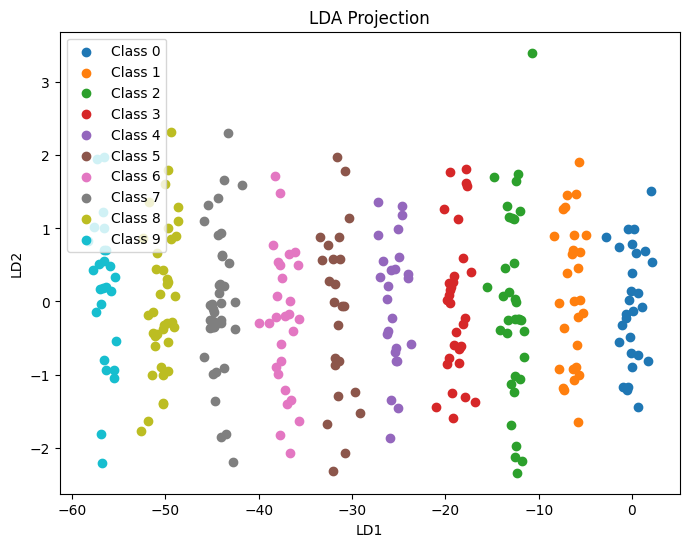

In [9]:
plot_lda_projection(X_test_lda, y_test, "LDA Projection")
